# Behaviour Estimation

## Import Libraries

In [1]:
import train_network as tn
import frame_feature_extractor as ffe
import signal
import tensorflow as tf

from collections import deque
import cv2
import matplotlib as plt
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

Get Model

In [2]:
model = tn.get_trained_sequence_model(filepath='models/jump_skate_20frame_10epochs')

In [11]:
# Set Hyperparameters
SEQ_LEN = 20
THRESHOLD = .2

Start Camera

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

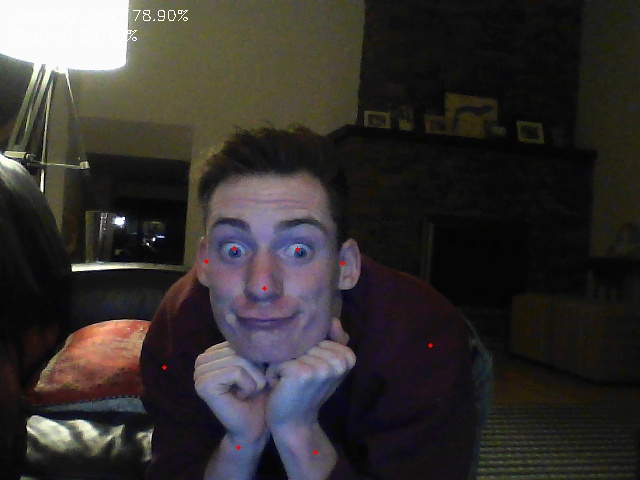

In [12]:
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    frame_queue = deque(maxlen=20)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = .5
    fontColor              = (255,255,255)
    thickness              = 1
    lineType               = 2

    while True:
        _, frame = cap.read()
        height, width, channels = frame.shape
        
        frame_features = ffe.get_features_from_image(frame)
        frame_queue.append(tf.keras.layers.Flatten()(frame_features))
        if len(frame_queue)<SEQ_LEN:
            continue
        x = tf.convert_to_tensor(list(frame_queue))
        x = tf.transpose(x, perm=[1, 0, 2])
        probabilities = model.predict(x)[0]
        
        for p in range(2):
            for f in frame_features[0][p]:
                if f[2] > THRESHOLD:
                    frame = cv2.circle(frame, (int(f[1]*width), int(f[0]*height)), radius=2, color=(0, (0 if p<1 else 255), 255), thickness=-1)
        
        cv2.putText(frame, f'Jumping Jack: {probabilities[0]*100:.2f}%', 
            (10, 20), font, fontScale, fontColor, thickness, lineType)
        cv2.putText(frame, f'Skating: {probabilities[1]*100:.2f}%', 
            (10, 40), font, fontScale, fontColor, thickness, lineType)
            
            
        _, frame = cv2.imencode('.jpeg', frame)

        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value:
            cap.release()
            display_handle.update(None)
            break


# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()